In [2]:
from typing import Callable
import doctest

from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt

### Test functions

In [22]:
QUINTIC_SOLUTION = 1.1673039782614185

def quintic(x: float) -> float:
    return x ** 5 - x - 1


def quintic_derivative(x: float) -> float:
    return 5 * x ** 4 - 1


def quintic_hess(x: float) -> float:
    return 20 * x ** 3


def quartic(x: float) -> float:
    return x ** 4 + x ** 3 - 4 * x ** 2 + x + 1


def quartic_derivative(x: float) -> float:
    return 4 * x ** 3 + 3 * x ** 2 - 8 * x + 1
    

def quartic_hess(x: float) -> float:
    return 12 * x ** 2 + 6 * x - 8

def lennard_jones(r:[float])->float:
    return 4*(np.power(1/r,12)-np.power(1/r,6))

import sympy as sp

r=sp.symbols('r')
lj=4*(1/r**12-1/r**6)

dlj=sp.diff(lj,r)
d2lj=sp.diff(dlj,r)

dlennard_jones=sp.lambdify(r, dlj, 'numpy')
d2lennard_jones=sp.lambdify(r, d2lj, 'numpy')

### Minimisers

In [59]:
LITTLE_PHI = (5 ** 0.5 - 1) / 2


def relative_error(a: float | None, b: float | None):
    if None in (a, b):
        return np.inf
    return abs((b - a) / (b + a))


def newton(f, df, d2f, x0, tol, force_minimum=False):
    """
    >>> newton(quintic, quintic_derivative, quintic_hess, 1.0, tol=1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    >>> newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16, force_minimum=True)  #doctest: +ELLIPSIS
    0.6687403...
    """
    sequence=[x0]
    a=x0
    condition=True
    
    if force_minimum==False:
        while condition:
            x=a-df(a)/d2f(a)
            sequence.append(x)
        
            if abs(a-x)<tol:
                condition=False
            a=x
    else:
        while condition:
            x=a-df(a)/abs(d2f(a))
            sequence.append(x)
        
            if abs(a-x)<tol:
                condition=False
            a=x
        
    return sequence[-1]   


def secant(f, df, x0, x1, tol):
    """
    >>> secant(quintic, quintic_derivative, 1.0, 1.1, tol=1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> secant(quintic, quintic_derivative, -1.1, -1.0, tol=1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    """
    a=x0
    b=x1
    
    while abs(a-b)>tol:
        c=b-df(b)*(b-a)/(df(b)-df(a))
        a=b
        b=c

    return c

def golden_section(f, a, b, tol):
    """
    >>> golden_section(quintic, -0.5, 1.0, 1e-7)  #doctest: +ELLIPSIS
    0.6687403...
    """
    
    phi=(np.sqrt(5)+1)/2
    c=b-(b-a)/phi

    while abs(a-b)>tol:
        d=a+b-c
        
        if f(d)>f(c):
            if d>c:
                b=d
            else:
                a=d
        else:
            if d>c:
                a=c
            else:
                b=c
            c=d
        
    return (a+b)/2

def successive_parabolic_interpolation(f, a, b, c, tol):
    """
    >>> successive_parabolic_interpolation(quintic, 0.1, 0.2, 0.3, 1e-16)  #doctest: +ELLIPSIS
    0.6687403...
    >>> successive_parabolic_interpolation(quintic, -0.3, -0.2, -0.1, 1e-16)  #doctest: +ELLIPSIS
    -0.6687403...
    """
    
    x0=a
    x1=b
    x2=c
    
    while max(x0,x1,x2)-min(x0,x1,x2)>tol:
        fa=f(x0)
        fb=f(x1)
        fc=f(x2)
        denom = x0*(fc-fb)+x1*(fa-fc)+x2*(fb-fa)
        if abs(denom) < 1e-30:
            d = (x1 + x2) / 2
        else:
            d = 1/2*(x0**2*(fc-fb)+x1**2*(fa-fc)+x2**2*(fb-fa)) / denom
        
        
        x0=x1
        x1=x2
        x2=d
        
    return d


def gradient_descent(f, df, x0, tol, alpha=1.0, c1=0.8, c2=0.9, t=0.5):
    """
    Best use on functions that are bounded from below!
    
    >>> gradient_descent(quartic, quartic_derivative, 0.5, tol=1e-10)  #doctest: +ELLIPSIS
    1.0000000...
    """
    x=x0
    step=alpha
    
    p=df(x)/abs(df(x))
    
    while f(x-step*p)>f(x)-step*c1*abs(df(x)):
        step=t*step
    y=x0-step*p
    
    
    while abs(df(y))>tol:
        step=abs((y-x)*(df(y)-df(x)))/(df(y)-df(x))**2
        z=y-step*df(y)
        x=y
        y=z

    return z

doctest.testmod(verbose=True)

Trying:
    golden_section(quintic, -0.5, 1.0, 1e-7)  #doctest: +ELLIPSIS
Expecting:
    0.6687403...
ok
Trying:
    gradient_descent(quartic, quartic_derivative, 0.5, tol=1e-10)  #doctest: +ELLIPSIS
Expecting:
    1.0000000...
ok
Trying:
    newton(quintic, quintic_derivative, quintic_hess, 1.0, tol=1e-16)  #doctest: +ELLIPSIS
Expecting:
    0.6687403...
ok
Trying:
    newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16)  #doctest: +ELLIPSIS
Expecting:
    -0.6687403...
ok
Trying:
    newton(quintic, quintic_derivative, quintic_hess, -0.5, tol=1e-16, force_minimum=True)  #doctest: +ELLIPSIS
Expecting:
    0.6687403...
ok
Trying:
    secant(quintic, quintic_derivative, 1.0, 1.1, tol=1e-16)  #doctest: +ELLIPSIS
Expecting:
    0.6687403...
ok
Trying:
    secant(quintic, quintic_derivative, -1.1, -1.0, tol=1e-16)  #doctest: +ELLIPSIS
Expecting:
    -0.6687403...
ok
Trying:
    successive_parabolic_interpolation(quintic, 0.1, 0.2, 0.3, 1e-16)  #doctest: +ELLIPSIS
Expecting:
 

TestResults(failed=0, attempted=9)

(-2.0, 5.0)

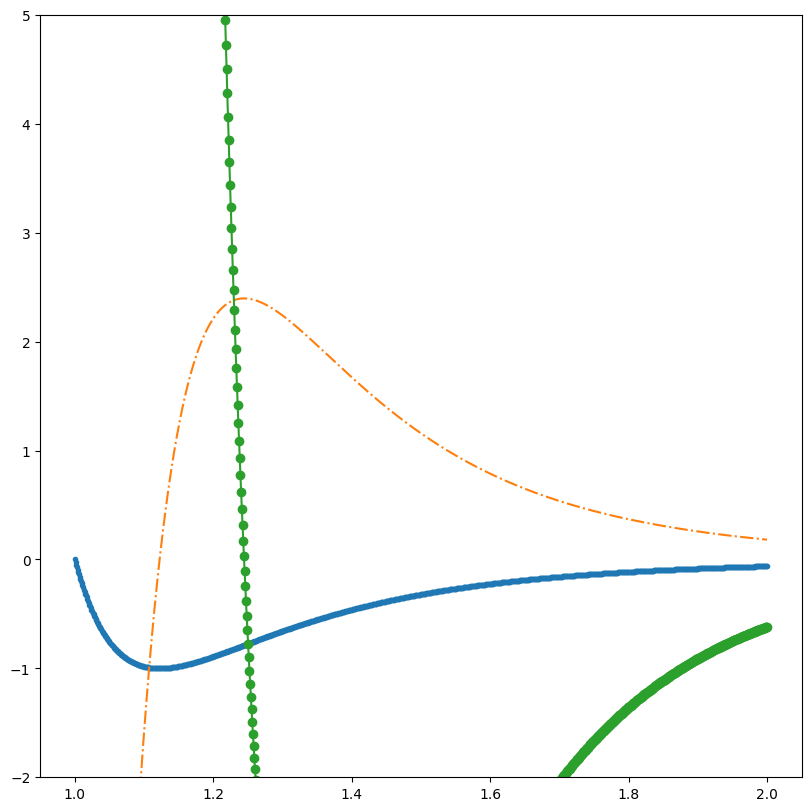

In [81]:
xo=np.linspace(1,2,1000)
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 8))
ax.plot(xo,lennard_jones(xo),'.-')
ax.plot(xo,dlennard_jones(xo),'-.')
ax.plot(xo,d2lennard_jones(xo),'-o')
ax.set_ylim(-2,5)


In [65]:
x0=np.linspace(0.8,1.5,10)
x=[newton(lennard_jones,dlennard_jones,d2lennard_jones,a,1e-8) for a in x0]
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 8))
ax.plot(x0,x,'-')

/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_21706/3236939074.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  x=a-df(a)/d2f(a)
/var/folders/26/33gfkypd2f930_67mdqmxs8m0000gn/T/ipykernel_21706/3236939074.py:25: RuntimeWarning: invalid value encountered in scalar divide
  x=a-df(a)/d2f(a)


KeyboardInterrupt: 

In [31]:
newton(lennard_jones,dlennard_jones,d2lennard_jones,1,1e-7)

np.set_printoptions(formatter={'float_kind': '{:.5f}'.format})
d2lennard_jones(newton(lennard_jones,dlennard_jones,d2lennard_jones,1,1e-7))
dx=newton(lennard_jones,dlennard_jones,d2lennard_jones,1,1e-7)[1:]-newton(lennard_jones,dlennard_jones,d2lennard_jones,1,1e-7)[:-1]
print(dx)

[0.05263 0.04086 0.02263 0.00598 0.00036 0.00000 0.00000]


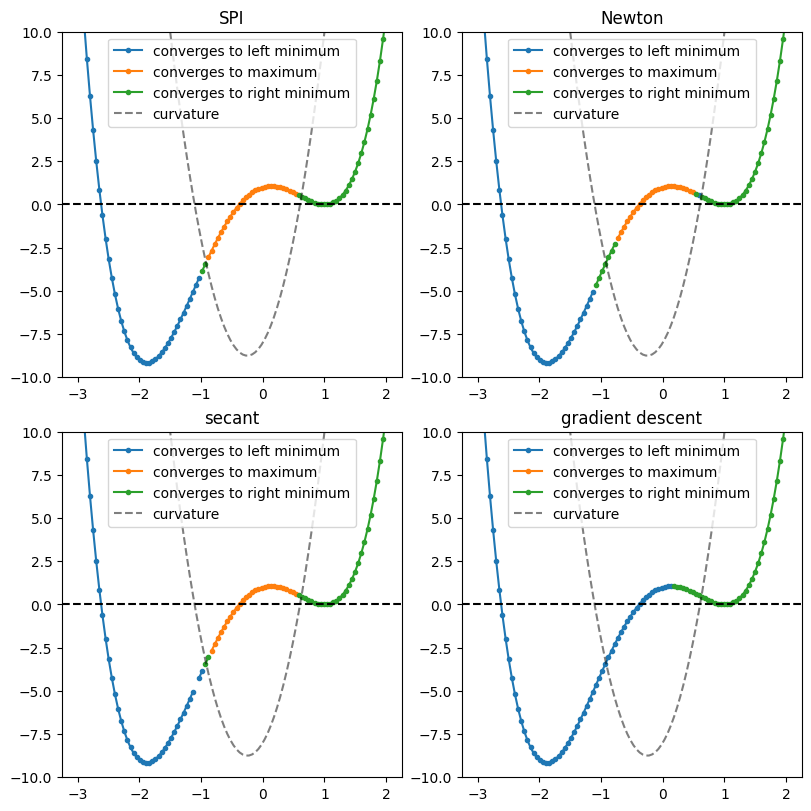

In [58]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 8))
axes = axes.flatten()

xs = np.linspace(-3, 2, 100)
f = quartic
df = quartic_derivative
d2f = quartic_hess
tol = 1e-8
step = 1e-3

stationary_points = (
    ("left minimum", -1.88278227),
    ("maximum", 0.13278222),
    ("right minimum", 1.0),
)

solutionss = [
    ("SPI", np.array([successive_parabolic_interpolation(f, x0, x0 + step, x0 + 2*step, tol) for x0 in xs])),
    ("Newton", np.array([newton(f, df, d2f, x0, tol) for x0 in xs])),
    ("secant", np.array([secant(f, df, x0, x0 + step, tol) for x0 in xs])),
    ("gradient descent", np.array([gradient_descent(f, df, x0, tol) for x0 in xs])),
]

for ax, (name, solutions) in zip(axes, solutionss):
    for label, p in stationary_points:
        ys = np.where(np.isclose(solutions, p) , xs, np.nan)
        ax.plot(ys, f(ys), '.-', label=f"converges to {label}") 
        ax.set_title(name)

for ax in axes:
    ax.plot(xs, d2f(xs), 'k--', alpha=0.5, label="curvature")
    ax.axhline(0, color='k', linestyle='--')
    ax.set_ylim(-10, 10)
    ax.legend()
    
plt.savefig("convergence.png")